[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/crunchdao/quickstarters/blob/main/competitions/causality-discovery/baseline/baseline.ipynb)

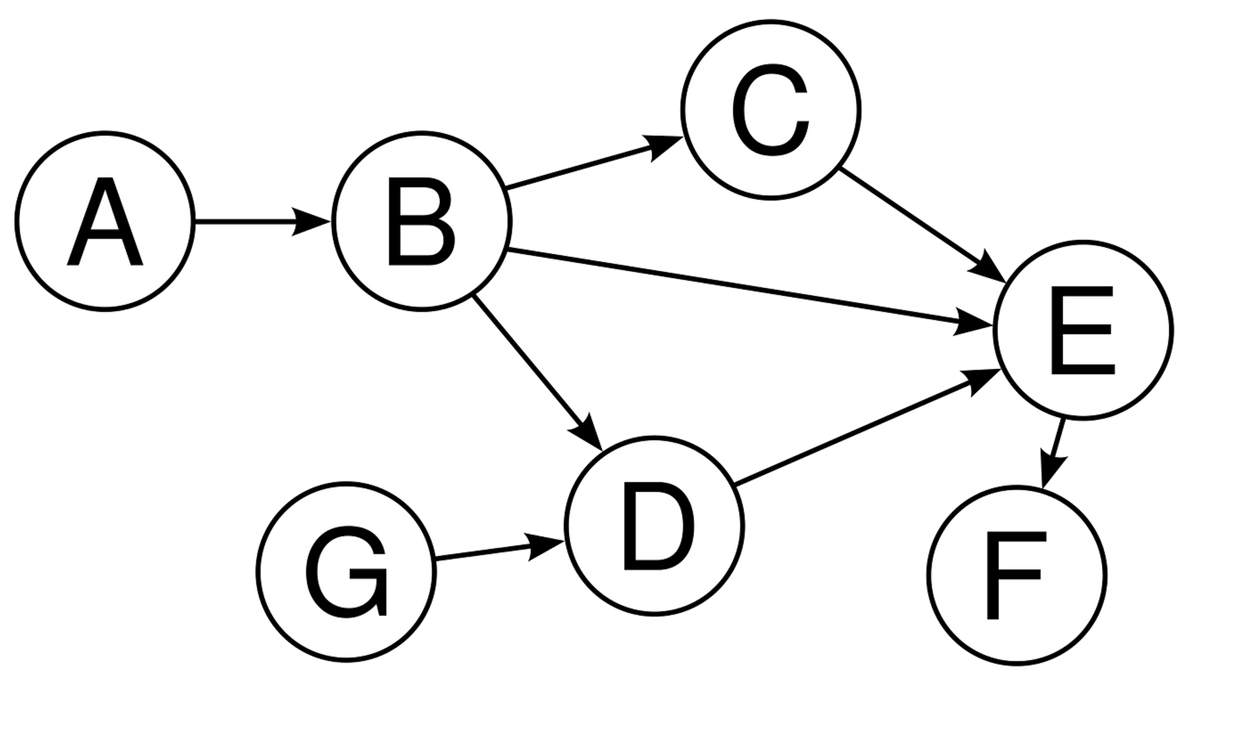

## DAG Competition - Baseline Notebook

The purpose of this notebook is both to introduce participants to the competition and to suggest some possible starting points. The suggestions presented here are not binding, of course, and can be taken in any number of directions.

## The problem

The problem of discovering causal relationships among variables from observational data is important in fields like healthcare and economics. Participants in this competition receive datasets with known causal graphs to develop algorithms that reveal the underlying causal structures. The focus is on identifying how other variables influence the relationship between two key variables, X (treatment) and Y (outcome). Both unsupervised and supervised methods are welcome, with evaluation based on the accuracy of predicted causal links. Successful solutions will improve causal inference methods, aiding decision-making and understanding in various domains.

### Preliminary step

In [ ]:
%pip install crunch-cli --upgrade
%pip install gcastle torch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.2 MB/s eta 0:00:00
  Created wheel for gitignorefile: filename=gitignorefile-1.1.2-py3-none-any.whl size=6671 sha256=f856d953a70a22733396f5e384c27e672b0f97fe0c12cc561c1adc26314de3b7
  Stored in directory: /root/.cache/pip/wheels/6d/dc/c7/5875272151d55a37a44c163d1bddb1cdfff35278b82dcf4ba7
Successfully built gitignorefile
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 5.7 MB/s eta 0:00:00


In [ ]:
# update the token via https://hub.crunchdao.com/competitions/causality-discovery/submit/via/notebook

!crunch setup --notebook causality-discovery default --token ggtrCoFAc4DzPKTWpoP90ccplJmIIXNJxq4vzJNEgGgtojoOhn7LLeqaFz5hht7s

download main.py from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/11301/main.py (33603 bytes)
download notebook.ipynb from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/11301/notebook.ipynb (413842 bytes)
download requirements.txt from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/11301/requirements.original.txt (201 bytes)
download data/X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
download data/y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
download data/X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
download data/y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-rel

In [ ]:
import os
import typing

#import castle.algorithms
import joblib
import networkx as nx
#import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import time

In [ ]:
import copy
import math
from math import log, pi
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from tqdm.auto import tqdm


class LocallyConnected(nn.Module):
    """Local linear layer, i.e. Conv1dLocal() with filter size 1.

    Args:
        num_linear: num of local linear layers, i.e.
        in_features: m1
        out_features: m2
        bias: whether to include bias or not

    Shape:
        - Input: [n, d, m1]
        - Output: [n, d, m2]

    Attributes:
        weight: [d, m1, m2]
        bias: [d, m2]
    """

    def __init__(self, num_linear, input_features, output_features, bias=True):
        super(LocallyConnected, self).__init__()
        self.num_linear = num_linear
        self.input_features = input_features
        self.output_features = output_features

        self.weight = nn.Parameter(torch.Tensor(num_linear,
                                                input_features,
                                                output_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(num_linear, output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        self.reset_parameters()

    @torch.no_grad()
    def reset_parameters(self):
        k = 1.0 / self.input_features
        bound = math.sqrt(k)
        nn.init.uniform_(self.weight, -bound, bound)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor):
        # [n, d, 1, m2] = [n, d, 1, m1] @ [1, d, m1, m2]
        out = torch.matmul(input.unsqueeze(dim=2), self.weight.unsqueeze(dim=0))
        out = out.squeeze(dim=2)
        if self.bias is not None:
            # [n, d, m2] += [d, m2]
            out += self.bias
        return out

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'num_linear={}, in_features={}, out_features={}, bias={}'.format(
            self.num_linear, self.in_features, self.out_features,
            self.bias is not None
        )


def adjacency_matrix_to_dict(W, dont_include_self_loops=True):
    '''
    Returns a dictionary of the form {'W[i][j]': W[i,j]} for all i,j
    '''
    W_dict = {}
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if dont_include_self_loops:
                if i != j:
                    W_dict[f'W[{i}][{j}]'] = W[i,j]
    return W_dict

class Spindly(nn.Module):
    def __init__(self, in_features):
        super(Spindly, self).__init__()
        self.weight = nn.Parameter(torch.zeros(in_features))

    def reset_parameters(self):
        nn.init.constant_(self.weight, 0)

    def forward(self, input):
        return input * self.weight


class SEM_Dataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]


def stable_softplus(input):
   return nn.functional.softplus(input) + 1e-8


def get_head_activation(act_str):
    if act_str == 'softplus':
        return stable_softplus
    elif act_str == 'exp':
        return torch.exp
    else:
        raise ValueError('Invalid activation string', act_str)


def get_hidden_activation(act_str):
    if act_str == 'GELU':
        return torch.nn.GELU()
    elif act_str == 'ReLU':
        return torch.nn.ReLU()
    elif act_str == 'sigmoid':
        return torch.nn.Sigmoid()
    else:
        raise ValueError('Invalid activation string', act_str)


class DagmaNN(nn.Module):

    def __init__(self, dims, bias=True, LSN=False, natural_param=False, hidden_act_str='GELU', variance_act_str='softplus'):
        super(DagmaNN, self).__init__()
        assert len(dims) >= 2
        self.tracker = []
        self.LSN = LSN
        self.hidden_activation = get_hidden_activation(hidden_act_str)
        self.natural_param = natural_param
        if self.LSN:
            assert dims[-1] == 2
            self.head_activation_variance = get_head_activation(variance_act_str)
        else:
            assert dims[-1] == 1
        self.dims, self.d = dims, dims[0]
        self.I = torch.eye(self.d)

        self.fc1 = nn.Linear(self.d, self.d * dims[1], bias=bias)
        nn.init.zeros_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        # fc2: local linear layers
        layers = []
        for l in range(len(dims) - 2):
            layers.append(LocallyConnected(self.d, dims[l + 1], dims[l + 2], bias=bias))
        self.fc2 = nn.ModuleList(layers)

    def forward(self, x):  # [n, d] -> [n, d]
        x = self.fc1(x)
        x = x.view(-1, self.dims[0], self.dims[1])
        for fc in self.fc2:
            x = self.hidden_activation(x)
            x = fc(x)

        if self.LSN:
            f0 = x[:,:,0]
            f1 = self.head_activation_variance(x[:,:,1]) # mu, sigma^2 [i, j] i=1,..,n j=1,...,d
            if self.natural_param:
                eta_1 = f0
                eta_2 = -0.5 * f1
                return eta_1, eta_2
            else:
                return f0, f1
        else:
            return x.squeeze(dim=2) # mu [i, j] i=1,..,n j=1,...,d

    def h_func(self, s=1.0):
        """Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG"""
        fc1_weight = self.fc1.weight
        fc1_weight = fc1_weight.view(self.d, -1, self.d)
        A = torch.sum(fc1_weight ** 2, dim=1).t()  # [i, j]
        h = -torch.slogdet(s * self.I - A)[1] + self.d * np.log(s)
        return h

    def fc1_l1_reg(self):
        """Take l1 norm of fc1 weight"""
        return torch.sum(torch.abs(self.fc1.weight))

    def fc1_l1_group_lasso(self):
        """Take group lasso penalty where the groups are the columns of A_j^{1}"""
        fc1_weight = self.fc1.weight
        fc1_weight = fc1_weight.view(self.d, -1, self.d)
        A = torch.sum(fc1_weight ** 2, dim=1).t()
        W = torch.sqrt(A)

        return torch.sum(A)

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:  # [j * m1, i] -> [i, j]
        """Get W from fc1 weights, take 2-norm over m1 dim"""
        fc1_weight = self.fc1.weight
        fc1_weight = fc1_weight.view(self.d, -1, self.d)
        A = torch.sum(fc1_weight ** 2, dim=1).t()
        W = torch.sqrt(A)
        W = W.cpu().detach().numpy()  # [i, j]
        return W


class DagmaNN_no_self_loops(nn.Module):

    def __init__(self, dims, bias=True, LSN=False, natural_param=False, hidden_act_str='GELU',
                 variance_act_str='softplus', spindly_layer=False, edge_clamp_range=None):
        super(DagmaNN_no_self_loops, self).__init__()
        assert len(dims) >= 2
        self.tracker = []
        self.spindly_layer = spindly_layer
        self.LSN = LSN
        self.hidden_activation = get_hidden_activation(hidden_act_str)
        self.natural_param = natural_param
        if self.LSN:
            assert dims[-1] == 2
            self.head_activation_variance = get_head_activation(variance_act_str)
        else:
            assert dims[-1] == 1
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.dims, self.d = dims, dims[0]
        self.I = torch.eye(self.d, device=self.device)
        self.edge_clamp_range_init = edge_clamp_range
        self.edge_clamp_range = self.edge_clamp_range_init
        self.to_keep = (torch.ones((self.d, self.d)) - torch.eye(self.d)).to(self.device) # remeber edges that are clamped by setting them to zero


        # it is required for barrier methods to start at the interior
        # of the feasibility region, thus W has to be a DAG
        # (trivially true if all weights are zero).
        if self.spindly_layer:
            # spindly layer
            self.spindly_list = []
            for i in range(self.d):
                self.spindly_list.append(Spindly(in_features=self.d-1))
                self.spindly_list = nn.ModuleList(self.spindly_list)
            # fc1: one additional local linear layer needed after the spindly layer.
            self.fc1 = nn.ModuleList([LocallyConnected(self.d, self.d - 1, dims[1], bias=bias)])
        else:
            # special fc1 layer that does not induce self-loops
            layers = []
            for i in range(self.d):
                fc = torch.nn.Linear(in_features=self.d - 1, out_features=dims[1], bias=True)
                nn.init.zeros_(fc.weight)
                nn.init.zeros_(fc.bias)
                layers.append(fc)
            self.special_fc1 = nn.ModuleList(layers)

        # fc2: local linear layers
        self.batch_norm_layers = [] # for every hidden layer we have d local batch layers
        layers = []
        for l in range(len(dims) - 2):
            layers.append(LocallyConnected(self.d, dims[l + 1], dims[l + 2], bias=bias))
            self.batch_norm_layers.append([nn.BatchNorm1d(self.dims[l + 1]) for _ in range(self.d)])
        self.fc2 = nn.ModuleList(layers)

    def forward(self, x):  # [n, d] -> [n, d]
        if self.spindly_layer:
            # spindly layer
            out = [None] * self.d
            input_idxes = list(range(self.d))
            for i in range(self.d):
                input_idx = input_idxes.copy()
                input_idx.remove(i)
                out[i] = self.spindly_list[i](x[:, input_idx])
            x = torch.cat(out, 1)
            # fc1
            x = x.view(-1, self.d, self.d - 1)
            x = self.fc1[0](x)
        else:
            # special fc1 layer
            out = [None] * self.d
            input_idxes = list(range(self.d))
            for i in range(self.d):
                input_idx = input_idxes.copy()
                input_idx.remove(i)
                out[i] = self.special_fc1[i](x[:, input_idx])
            x = torch.cat(out, 1)
            x = x.view(-1, self.d, self.dims[1])

        # fc2
        for l, fc in enumerate(self.fc2):

            ## batch norm
            #outputs = []
            #for d, batch_norm in enumerate(self.batch_norm_layers[l]):
            #    outputs.append(batch_norm(x[:,d,:]))
            #x = torch.stack(outputs, dim=1)

            x = self.hidden_activation(x)
            x = fc(x)

        if self.LSN:
            f0 = x[:,:,0]
            f1 = self.head_activation_variance(x[:,:,1]) # mu, sigma^2 [i, j] i=1,..,n j=1,...,d
            if self.natural_param:
                eta_1 = f0
                eta_2 = -0.5 * f1
                return eta_1, eta_2
            else:
                return f0, f1
        else:
            return x.squeeze(dim=2) # mu [i, j] i=1,..,n j=1,...,d

    def h_func(self, s=1.0):
        """Constrain weighted adjacency matrics to be a DAG"""
        A = torch.zeros([self.d, self.d], device=self.device)
        if self.spindly_layer:
            input_idxes = list(range(self.d))
            for i in range(self.d):
                input_idx = input_idxes.copy()
                input_idx.remove(i)
                A[input_idx, i] = self.spindly_list[i].weight ** 2
        else:
            input_idxes = list(range(self.d))
            for i in range(self.d):
                input_idx = input_idxes.copy()
                input_idx.remove(i)
                A[input_idx, i] = torch.sum(self.special_fc1[i].weight ** 2, dim=0)

        # clamp edges
        with torch.no_grad():
            to_keep_ = (torch.sqrt(A) >= self.edge_clamp_range).type(torch.Tensor).to(self.device)
            self.to_keep *= to_keep_
            A *= self.to_keep
        h = -torch.slogdet(s * self.I - A)[1] + self.d * np.log(s)
        return h

    def fc1_l1_reg(self):
        """Take l1 norm of fc1 weights"""
        penalty = 0
        if self.spindly_layer:
            # spindly layer
            for spindly in self.spindly_list:
                penalty += torch.sum(torch.abs(spindly.weight))
            # fc1
            penalty += torch.sum(torch.abs(self.fc1[0].weight))
        else:
            for layer in self.special_fc1:
                penalty += torch.sum(torch.abs(layer.weight))
        return penalty

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:  # [list of weights] -> [i, j]
        """Get W from neural networks weights"""
        if self.spindly_layer:
            # Get W from Spindly-layer weights
            A = torch.zeros([self.d, self.d])
            input_idxes = list(range(self.d))
            for i in range(self.d):
                input_idx = input_idxes.copy()
                input_idx.remove(i)
                A[input_idx, i] = self.spindly_list[i].weight ** 2
        else:
            # Get W from fc1 weights
            A = torch.zeros([self.d, self.d], device=self.device)
            input_idxes = list(range(self.d))
            for i in range(self.d):
                input_idx = input_idxes.copy()
                input_idx.remove(i)
                A[input_idx, i] = torch.sum(self.special_fc1[i].weight ** 2, dim=0)
        W = torch.sqrt(A)
        to_keep_ = (W >= self.edge_clamp_range).type(torch.Tensor).to(self.device)
        self.to_keep *= to_keep_
        W *= self.to_keep
        W = W.cpu().detach().numpy()  # [i, j]
        return W


def log_mse_loss(output, target):
    n, d = target.shape
    loss = 0.5 * d * torch.log(1 / n * torch.sum((output - target) ** 2))
    return loss


def heteroscedastic_mse_loss(input, target, reduction='mean'):
    """Heteroscedastic negative log likelihood Normal.
    Parameters
    ----------
    input : torch.Tensor (n, 2)
        two natural parameters per data point
    target : torch.Tensor (n, 1)
        targets
    reduction : str
        either 'mean' or 'sum'
    returns
    -------
    torch.Tensor
        negative log likelihood
    """
    assert input.ndim == target.ndim == 2
    assert input.shape[0] == target.shape[0]
    n, _ = input.shape
    C = - 0.5 * log(2 * pi)
    target = torch.cat([target, target.square()], dim=1)
    inner = torch.einsum('nk,nk->n', target, input)
    log_A = input[:, 0].square() / (4 * input[:, 1]) + 0.5 * torch.log(- 2 * input[:, 1])
    log_lik = n * C + inner.sum() + log_A.sum()
    if reduction == 'mean':
        return - log_lik / n
    elif reduction == 'sum':
        return - log_lik
    else:
        raise ValueError('Invalid reduction', reduction)


def beta_Gaussian_NLLLoss(input, target, var, beta=0.5, reduction='mean', full=True, eps=1e-6):
    """Beta-Gaussian negative log likelihood.
    Parameters
    ----------
    input : torch.Tensor (n, 1)
        mean predictions
    target : torch.Tensor (n, 1)
        mean targets
    var : torch.Tensor (n, 1)
        variance predictions
    beta : float
        between 0 and 1
    reduction : str
        either 'mean' or 'sum'
    full : bool
        whether to include the constant term in the loss
    eps : float
        lower bound for variance
    returns
    -------
    torch.Tensor
        The loss.
    """
    # Entries of var must be non-negative
    if torch.any(var < 0):
        raise ValueError("var has negative entry/entries")

    # Clamp for stability
    var = var.clone()
    with torch.no_grad():
        var.clamp_(min=eps)

    loss = 0.5 * (torch.log(var) + (input - target) ** 2 / var)
    if full:
        loss += 0.5 * log(2 * pi)
    loss = loss * var.detach() ** beta

    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()


def generic_loss(model, Xb, beta_NLL, s, group_lasso, lambda1, mu, homo_loss=None):
    """Calculates the loss corresponding the the right model and parametrization.
    Parameters
    ----------
    model : Model
        The model to calculate the loss for.
    Xb : torch.Tensor
        Batch of design matrix
    beta_NLL : float
        The beta parameter for the beta-Gaussian likelihood.
    s : int
        Specific DAGMA penalty.
    group_lasso : bool
        Specifies whether group lasso (True) or the lasso penalty (False) is used.
    lambda1 : float
        The weight for the lasso penalty.
    mu : float
        The weight for the score.
    homo_loss : str, optional
        The type of homoscedastic loss to use. One of 'log_mse' or 'NLL'. Defaults to None.

    Returns
    -------
    torch.Tensor
        The loss.
    """
    assert beta_NLL >= 0
    ## likelihood
    if model.LSN:
        d = Xb.shape[1]
        neg_lik = 0
        if model.natural_param:
            eta_1, eta_2 = model(Xb)
            for j in range(d):
                neg_lik += heteroscedastic_mse_loss(
                    input=torch.stack([eta_1[:,j], eta_2[:,j]], 1),
                    target=Xb[:,j].unsqueeze(-1),
                    reduction='mean'
                )
            neg_lik /= d
        else:
            f0, f1 = model(Xb)
            for j in range(d):
                neg_lik += beta_Gaussian_NLLLoss(
                    input=f0[:,j].unsqueeze(-1),
                    target=Xb[:,j].unsqueeze(-1),
                    var=f1[:,j].unsqueeze(-1),
                    beta=beta_NLL, reduction='mean', eps=1e-6
                )
            neg_lik /= d
    else:
        f0 = model(Xb)
        if homo_loss == 'log_mse':
            neg_lik = log_mse_loss(f0, Xb)
        elif homo_loss == 'NLL':
            neg_lik = -torch.distributions.normal.Normal(loc=f0, scale=1).log_prob(Xb).mean()
        else:
            raise ValueError('Invalid homoscedastic loss', homo_loss)

    ## penalties
    h_val = model.h_func(s)
    if group_lasso:
        l1_penalty = lambda1 * model.fc1_l1_group_lasso()
    else:
        l1_penalty = lambda1 * model.fc1_l1_reg()

    obj = mu * (neg_lik + l1_penalty) + h_val
    return obj, neg_lik, h_val, l1_penalty


def minimize(model, X, max_iter, t, lr, lambda1, lambda2, group_lasso, mu, s, beta_NLL, batch_size,
             homo_loss=None, verbose=False, pbar=None, track_optimization=False, optimizer_type=False):
    if verbose:
      vprint = print
    else:
      vprint = lambda *a, **k: None
    vprint(f'\nMinimize s={s} -- lr={lr}')
    if optimizer_type == 'DAGMA-ADAM':
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(.99,.999), weight_decay=mu*lambda2)
    elif optimizer_type == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=mu*lambda2)
    elif optimizer_type == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters())
    else:
        raise ValueError('Invalid optimizer_type: ', optimizer_type)

    train_data = SEM_Dataset(X)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    #if lr_decay is True:
    #    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X = X.to(device)
    for i in range(max_iter):
        model.train()
        # first iteration no edge clamping
        if t==0:
            model.edge_clamp_range = 0
        else:
            model.edge_clamp_range = model.edge_clamp_range_init
        for Xb in train_dataloader:
            Xb = Xb.to(device)
            obj_b, _, h_val_b, _ = generic_loss(model, Xb, beta_NLL, s, group_lasso, lambda1, mu, homo_loss)
            if h_val_b.item() < -0.000001:
                vprint(f'Found h negative {h_val_b.item()} at iter {i}')
                return False
            obj_b.backward()
            optimizer.step()
            optimizer.zero_grad()

        # stores performance after performing epoch i
        if track_optimization:
            model.eval()
            obj, neg_lik, h_val, _ = generic_loss(model, X, beta_NLL, s, group_lasso, lambda1, mu, homo_loss)
            perf_dict = {
                "t": t,
                "epoch": i,
                "obj": obj.item(),
                "neg_lik": neg_lik.item(),
                "h_val": h_val.item(),
            }
            perf_dict = {**perf_dict, **adjacency_matrix_to_dict(model.fc1_to_adj())}
            model.tracker.append(perf_dict)

    # store final values
    model.eval()
    obj, neg_lik, h_val, l1_penalty = generic_loss(model, X, beta_NLL, s, group_lasso, lambda1, mu, homo_loss)
    obj_new = obj.item()
    model.loss_store = {"obj": obj_new, "neg_lik": neg_lik.item(), "h_val": h_val.item(), "l1_penalty": l1_penalty.item()}

    pbar.update(max_iter)
    return True


def dagma_nonlinear(
        model: nn.Module, X: torch.tensor, lambda1=.02, lambda2=.005, group_lasso=False,
        T=4, mu_init=.1, mu_factor=.1, s=1.0, warm_iter=5e4, max_iter=8e4, lr=.0002,
        beta_NLL=0, homo_loss=None, batch_size=None, lr_outer_iter_decay=False,
        w_threshold=0.3, verbose=False, track_optimization=False, track_models=False,
        optimizer_type='ADAM'
    ):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    if verbose:
      vprint = print
    else:
      vprint = lambda *a, **k: None
    mu = mu_init
    if type(s) == list:
        if len(s) < T:
            vprint(f"Length of s is {len(s)}, using last value in s for iteration t >= {len(s)}")
            s = s + (T - len(s)) * [s[-1]]
    elif type(s) in [int, float]:
        s = T * [s]
    else:
        ValueError("s should be a list, int, or float.")
    with tqdm(total=(T-1)*warm_iter+max_iter) as pbar:
        model_tracker = []
        if track_models:
            model_tracker.append({'t': 'init', 'model': copy.deepcopy(model)}) # save initial model
        for t in range(int(T)):
            vprint(f'\nDagma iter t={t+1} -- mu: {mu}', 30*'-')
            success, s_cur = False, s[t]
            inner_iter = int(max_iter) if t == T - 1 else int(warm_iter)
            model_copy = copy.deepcopy(model)
            while success is False:
                success = minimize(
                    model, X, inner_iter, t, lr, lambda1, lambda2, group_lasso, mu, s_cur, beta_NLL, batch_size,
                    homo_loss=homo_loss, verbose=verbose, pbar=pbar, track_optimization=track_optimization,
                    optimizer_type=optimizer_type
                )
                if success is False:
                    model.load_state_dict(model_copy.state_dict().copy())
                    lr *= 0.5
                    if lr < 1e-10:
                        break # lr is too small
                    s_cur = 1

            if lr_outer_iter_decay:
                lr *= 0.9
            mu *= mu_factor
            if track_models:
                model_tracker.append({'t': t, 'model': copy.deepcopy(model)})
    W_est = model.fc1_to_adj()
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est, model_tracker

In [ ]:
#import igraph as ig
#
#def is_dag(W):
#    G = ig.Graph.Weighted_Adjacency(W.tolist())
#    return G.is_dag()

def count_accuracy(B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """

    #if not ((B_est == 0) | (B_est == 1)).all():
    #  raise ValueError('B_est should take value in {0,1}')
    #if not is_dag(B_est):
    #  raise ValueError('B_est should be a DAG')

    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

def show_matrices_side_by_side(B_est, B_true):
  """Displays two matrices side-by-side with labels.

  Args:
    B_est: The first matrix to display.
    B_true: The second matrix to display.
  """
  fig, axes = plt.subplots(1, 2, figsize=(6, 3))

  # Assuming your matrices have labels as row/column names
  labels_B_est = B_est.index
  labels_y_est = B_true.index

  # Display the first matrix
  im1 = axes[0].imshow(B_est, cmap='viridis', interpolation='nearest')
  axes[0].set_title('B_est')
  axes[0].set_xticks(np.arange(len(labels_B_est)))
  axes[0].set_yticks(np.arange(len(labels_B_est)))
  axes[0].set_xticklabels(labels_B_est)
  axes[0].set_yticklabels(labels_B_est)

  # Display the second matrix
  im2 = axes[1].imshow(B_true, cmap='viridis', interpolation='nearest')
  axes[1].set_title('B_true')
  axes[1].set_xticks(np.arange(len(labels_y_est)))
  axes[1].set_yticks(np.arange(len(labels_y_est)))
  axes[1].set_xticklabels(labels_y_est)
  axes[1].set_yticklabels(labels_y_est)

  plt.tight_layout()
  plt.show()


In [ ]:
import crunch
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>


The following function is provided to help you get a DAG from your predicted graph, if it is not a DAG, also ensuring that there is an edge from X to Y as designed. This is only one way to get such a result, and not necessarily optimal for competition. An improved algorithm for obtaining a DAG from your predicted graph could lead to better results.

In [ ]:
def fix_DAG(g):
    """
    Ensure that the graph is a DAG and has an edge X→Y

    We look for cycles, and remove an edge in each cycle, until there are no cycles left.

    Inputs: g: nx.DiGraph
    Output: g: nx.DiGraph

    This function provides just a possible solution to the problem
    of DAG-ifying a graph. Other solutions can be conceived that could
    be better for the competition.
    """

    assert 'X' in g.nodes
    assert 'Y' in g.nodes

    gg = g.copy()

    # Add X→Y if it is missing
    if ('X', 'Y') not in gg.edges:
        gg.add_edge('X', 'Y')

    # Look for cycles and remove them
    while not nx.is_directed_acyclic_graph(gg):

        h = gg.copy()

        # Remove all the sources and sinks
        while True:
            finished = True

            for i, v in nx.in_degree_centrality(h).items():
                if v == 0:
                    h.remove_node(i)
                    finished = False

            for i, v in nx.out_degree_centrality(h).items():
                if v == 0:
                    h.remove_node(i)
                    finished = False

            if finished:
                break

        # Find a cycle, with a random walk starting at a random node
        node = list(h.nodes)[0]
        cycle = [node]
        while True:
            edges = list(h.out_edges(node))
            _, node = edges[np.random.choice(len(edges))]

            if node in cycle:
                break

            cycle.append(node)

        # We have a path that ends with a cycle: remove the begining, if it is not part of the cycle
        cycle = np.array(cycle)
        i = np.argwhere(cycle == node)[0][0]
        cycle = cycle[i:]
        cycle = cycle.tolist() + [node]

        # Edges in that cycle
        edges = list(zip(cycle[:-1], cycle[1:]))

        # Pick an edge at random, but make sure it is not X→Y -- we want to keep that one
        edges = [e for e in edges if e != ('X', 'Y')]
        edge = edges[np.random.choice(len(edges))]

        gg.remove_edge(*edge)

    return gg

In [ ]:
def dagma_lsn_natural(X):
  # configure model
  torch.set_default_dtype(torch.double)
  model = 'DAGMA-LSN-natural' #['DAGMA-adj', 'DAGMA-LSN', 'DAGMA-LSN-natural']
  fc1_type = 'no_self_loops'
  nbr_hidden_units = 50
  hidden_act_str = 'GELU'
  variance_act_str = 'softplus'
  edge_clamp_range=0.1
  spindly_layer=False

  # configure training
  lambda1 = 0.0025 # AN: 0.001, AN-s: 0.0025
  lambda2 = 0.0001 # AN: 0.0001, AN-s: 0.00005
  batch_size = 200
  lr = 0.01
  lr_outer_iter_decay = True
  mu_init = 1000
  mu_factor = 0.4 #0.6
  verbose = False

  warm_iter = 3#1000
  max_iter = 5#5000
  T = 15 #50

  optimizer_type = 'ADAM'
  train_val_split = False
  homo_loss = False
  beta_NLL = 0
  track_optimization = False
  track_models = False # track models after every iteration

  X = X.to_numpy()
  X = StandardScaler().fit_transform(X)
  d = X.shape[1]
  dims = [d, nbr_hidden_units]
  dims.append(2)
  X_torch = torch.from_numpy(X)

  model = DagmaNN_no_self_loops(dims=dims, LSN=True, natural_param=True, hidden_act_str=hidden_act_str, variance_act_str=variance_act_str, spindly_layer=spindly_layer, edge_clamp_range=edge_clamp_range)
  #model = DagmaNN.             (dims, bias=True, LSN=True, natural_param=True, hidden_act_str=hidden_act_str, variance_act_str='softplus'):
  W_est, model_tracker = dagma_nonlinear(model, X_torch, lambda1=lambda1, lambda2=lambda2, mu_init=mu_init, mu_factor=mu_factor, w_threshold=0, batch_size=batch_size, homo_loss=homo_loss, lr=lr, lr_outer_iter_decay=lr_outer_iter_decay, optimizer_type=optimizer_type, beta_NLL=beta_NLL, verbose=verbose, warm_iter=warm_iter, max_iter=max_iter, T=T, track_optimization=track_optimization, track_models=track_models)
  return W_est

This is the core of the solution's code, which reads one record at a time, applies the PC algorithm, ensures that the result is a DAG, and then puts the result into a single data frame in the required format, ready for submission.

In [ ]:
# Uncomment what you need!
def train(
    X_train: typing.Dict[str, pd.DataFrame],
    y_train: typing.Dict[str, pd.DataFrame],
    # number_of_features: int,
    model_directory_path: str,
    # id_column_name: str,
    # prediction_column_name: str,
    # has_gpu: bool,
) -> None:
    # TODO replace me with a real model
    model = ...

    joblib.dump(
        model,
        os.path.join(model_directory_path, "model.joblib")
    )

In [ ]:
# Uncomment what you need!
def infer(
    X_test: typing.Dict[str, pd.DataFrame],
    # number_of_features: int,
    model_directory_path: str,
    id_column_name: str,
    prediction_column_name: str,
    # has_gpu: bool,
    # has_trained: bool,
) -> pd.DataFrame:
    # TODO use me
    # model = joblib.load(os.path.join(model_directory_path, "model.joblib"))

    predictions = {}
    for dataset_id in tqdm(X_test):
        X = X_test[dataset_id]

        nodes = X.columns
        W_est = dagma_lsn_natural(X)

        w_treshold = 0.3
        W_est_tresholded = copy.deepcopy(W_est)
        W_est_tresholded = (np.abs(W_est) >= w_treshold).astype(int)
        W_est_tresholded = pd.DataFrame(W_est_tresholded, columns=nodes, index=nodes)

        #model = castle.algorithms.PC()
        #model.learn(X)
        #A_hat = pd.DataFrame(model.causal_matrix, columns=nodes, index=nodes)

        g_hat = nx.from_pandas_adjacency(W_est_tresholded, create_using=nx.DiGraph)
        g_hat = fix_DAG(g_hat)

        G = pd.DataFrame(nx.to_numpy_array(g_hat).astype(int), columns=nodes, index=nodes)
        for i in nodes:
            for j in nodes:
                predictions[f'{dataset_id}_{i}_{j}'] = int(G.loc[i, j])

    return pd.DataFrame(
        predictions.items(),
        columns=[id_column_name, prediction_column_name]
    )

In [ ]:
X_train, y_train, X_test = crunch.load_data()

download data/X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data/y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data/X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data/y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data/example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exists: file length match


In [ ]:
X_train['01994']

,0,1,2,Y,4,5,6,X
0,0.559,-0.785,0.917,-0.011,-0.559,-0.099,0.961,-0.721
1,-0.771,-0.529,-0.107,0.889,0.771,-0.303,0.751,-0.361
2,-0.429,0.529,-0.457,-0.003,0.429,0.389,-0.011,0.591
3,0.651,-0.303,0.843,-0.321,-0.651,-0.251,0.723,-0.419
4,-0.265,0.267,-0.811,-0.281,0.265,-0.155,-0.013,0.917
...,...,...,...,...,...,...,...,...
995,-0.689,0.971,-0.683,0.313,0.689,-0.893,-0.769,0.743
996,0.969,-0.393,0.359,-0.997,-0.979,0.555,-0.891,-0.089
997,-0.279,0.863,-0.309,-0.101,0.279,-0.817,-0.357,0.463
998,0.939,-0.403,0.987,-0.263,-0.939,0.249,-0.431,-0.845


In [ ]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [ ]:
idx = '31253'

In [ ]:
idx = '46988'

In [ ]:
idx = '01994'

In [ ]:
X = X_train[idx]
nodes = X.columns

start_time = time.time()
W_est = dagma_lsn_natural(X)
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

  0%|          | 0/47 [00:00<?, ?it/s]

Execution time: 6.46717095375061 seconds


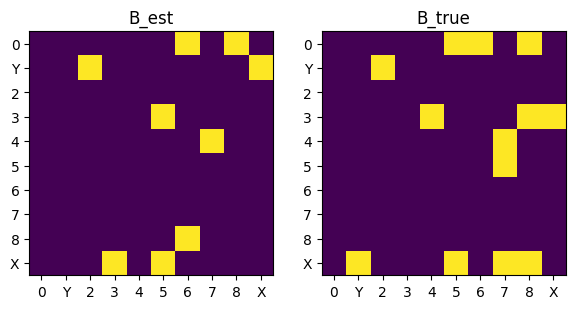

{'fdr': 0.4444444444444444,
 'tpr': 0.38461538461538464,
 'fpr': 0.125,
 'shd': 10,
 'nnz': 9}

In [ ]:
w_treshold = 0.3
W_est_tresholded = copy.deepcopy(W_est)
W_est_tresholded = (np.abs(W_est) >= w_treshold).astype(int)
W_est_tresholded = pd.DataFrame(W_est_tresholded, columns=nodes, index=nodes)

show_matrices_side_by_side(B_est=W_est_tresholded, B_true=y_train[idx])
count_accuracy(B_true=y_train[idx], B_est=W_est_tresholded)

In [ ]:
np.round(W_est, decimals=2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.31, 0.  , 1.36, 0.  ],
       [0.  , 0.  , 0.77, 0.3 , 0.  , 0.34, 0.  , 0.  , 0.  , 0.33],
       [0.  , 0.51, 0.  , 0.  , 0.  , 0.13, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.51, 0.32, 0.  , 0.  , 0.57, 0.  , 0.  , 0.  , 0.64],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.84, 0.  , 0.  ],
       [0.  , 0.44, 0.36, 0.43, 0.  , 0.  , 0.  , 0.  , 0.  , 0.46],
       [1.28, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.21, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.04, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.37, 0.  , 0.  , 0.  , 0.  , 0.  , 1.24, 0.  , 0.  , 0.  ],
       [0.  , 0.61, 0.41, 0.77, 0.  , 0.71, 0.  , 0.  , 0.  , 0.  ]])

In [ ]:
crunch.test(
    no_determinism_check=True
)

print("Download this notebook and submit it to the platform: https://hub.crunchdao.com/competitions/causality-discovery/submit/via/notebook")

ignoring cell #9: invalid syntax (<unknown>, line 2)


11:59:58 no forbidden library found
11:59:58 
11:59:58 started
11:59:58 running local test
11:59:58 internet access isn't restricted, no check will be done
11:59:58 
12:00:05 starting dag process...


download data/X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data/y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data/X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data/y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data/example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exists: file length match


12:00:14 call: train
12:00:14 call: infer


  0%|          | 0/1880 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

12:00:40 duration - time=00:00:42
12:00:40 memory - before="2.94 GB" after="4.65 GB" consumed="1.71 GB"


KeyboardInterrupt: 